In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

In [180]:
df_1 = pd.read_json('DATASET_FINAL.json')

df = df_1.copy()



In [181]:
# Groupement des acteurs 1, 2, 3 , scénaristes, réalisateurs, et distributeurs qui font plus de 500k entrées 
# + ajout d'un groupe "mid" entre 250k et 500k

# Acteur 1
df_actor_1 = df.groupby('actor_1')['weekly_entrances'].mean().reset_index()
df_actor_1_mid = df_actor_1[(df_actor_1['weekly_entrances'] < 500001) & (df_actor_1['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_1 = df_actor_1[df_actor_1['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 2
df_actor_2 = df.groupby('actor_2')['weekly_entrances'].mean().reset_index()
df_actor_2_mid = df_actor_2[(df_actor_2['weekly_entrances'] < 500001) & (df_actor_2['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_2 = df_actor_2[df_actor_2['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 3
df_actor_3 = df.groupby('actor_3')['weekly_entrances'].mean().reset_index()
df_actor_3_mid = df_actor_3[(df_actor_3['weekly_entrances'] < 500001) & (df_actor_3['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_3 = df_actor_3[df_actor_3['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Réalisateurs
df_directors = df.groupby('directors')['weekly_entrances'].mean().reset_index()
df_directors_mid = df_directors[(df_directors['weekly_entrances'] < 500001) & (df_directors['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_directors = df_directors[df_directors['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Scénaristes
df_writer = df.groupby('writer')['weekly_entrances'].mean().reset_index()
df_writer_mid = df_writer[(df_writer['weekly_entrances'] < 500001) & (df_writer['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_writer = df_writer[df_writer['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Distributeurs
df_distribution = df.groupby('distribution')['weekly_entrances'].mean().reset_index()
df_distribution_mid = df_distribution[(df_distribution['weekly_entrances'] < 500001) & (df_distribution['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_distribution = df_distribution[df_distribution['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)


In [182]:
# Création des colonnes "top" et "top_mid" pour les différents groupes

df['top_actor_1'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1['actor_1'].to_list() else 0)
df['top_actor_1_mid'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1_mid['actor_1'].to_list() else 0)

df['top_actor_2'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2['actor_2'].to_list() else 0)
df['top_actor_2_mid'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2_mid['actor_2'].to_list() else 0)

df['top_actor_3'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3['actor_3'].to_list() else 0)
df['top_actor_3_mid'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3_mid['actor_3'].to_list() else 0)

df['top_director'] = df['directors'].apply(lambda x: 1 if x in df_directors['directors'].to_list() else 0)
df['top_director_mid'] = df['directors'].apply(lambda x: 1 if x in df_directors_mid['directors'].to_list() else 0)

df['top_writer'] = df['writer'].apply(lambda x: 1 if x in df_writer['writer'].to_list() else 0)
df['top_writer_mid'] = df['writer'].apply(lambda x: 1 if x in df_writer_mid['writer'].to_list() else 0)

df['top_distribution'] = df['distribution'].apply(lambda x: 1 if x in df_distribution['distribution'].to_list() else 0)
df['top_distribution_mid'] = df['distribution'].apply(lambda x: 1 if x in df_distribution_mid['distribution'].to_list() else 0)


In [183]:
# Définition des bornes de classification (en dollars)
bins = [0,5_000_000, 30_000_000, 100_000_000, float('inf')]

# Noms des catégories correspondantes
labels = [
    # "Ultra low budget",
    "Low budget",
    "Mid budget",
    "High budget",
    "Blockbuster / AAA"
]

# Création de la nouvelle colonne "budget_category"
df['budget_category'] = pd.cut(df['budget'], bins=bins, labels=labels, right=False)

# Affichage du résultat
df.head()

df['top_pays'] = df.country.apply(lambda x : 1 if x in (['France','Etats-Unis','Grande-Bretagne']) else 0)

In [185]:
df.released_date=pd.to_datetime(df.released_date)

In [186]:
df["summer"] = df["released_date"].apply(lambda x: 1 if ((x.month == 6 and x.day >= 21) or x.month in [7, 8] or (x.month == 9 and x.day < 22)) else 0)
df["automn"] = df["released_date"].apply(lambda x: 1 if ((x.month == 9 and x.day >= 22) or x.month in [10, 11] or (x.month == 12 and x.day < 21)) else 0)
df["winter"] = df["released_date"].apply(lambda x: 1 if ((x.month == 12 and x.day >= 21) or x.month in [1, 2] or (x.month == 3 and x.day < 20)) else 0)
df["spring"] = df["released_date"].apply(lambda x: 1 if ((x.month == 3 and x.day >= 21) or x.month in [4, 5] or (x.month == 6 and x.day < 21)) else 0)

df["is_covid"] = df["released_date"].apply(lambda x: 1 if (
    (x >= pd.to_datetime("2020-03-17") and x <= pd.to_datetime("2020-05-11")) or
    (x >= pd.to_datetime("2020-10-30") and x <= pd.to_datetime("2020-12-15")) or
    (x >= pd.to_datetime("2021-04-03") and x <= pd.to_datetime("2021-05-03"))
) else 0)

df["post_streaming"] = df["released_date"].apply(lambda x: 1 if x >= pd.to_datetime("2014-09-15") else 0)

df["summer_holidays"] = df["released_date"].apply(lambda x: 1 if x.month >= 7 or (x.month <= 9 and x.day < 10) else 0)

df["christmas_period"] = df["released_date"].apply(lambda x: 1 if (x.month == 12 and x.day >= 20) or (x.month == 1 and x.day <= 5) else 0)

df["is_award_season"] = df["released_date"].apply(lambda x: 1 if (x.month == 2 or (x.month == 3 and x.day <= 10)) else 0)

df['month'] = df['released_date'].dt.month

In [187]:
features_of_interest = [
    # "actor_1",
    # "actor_2",
    # 'actor_3',
    # "directors",
    #  "writer",
    # "distribution",
    #"fr_title",
    'released_year',
    "country",
    #"budget",
    'category',
    'classification',
    'duration_minutes', 
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    #'budget_category',
    'top_pays',
    # 'summer',
    # 'automn',
    # 'winter',
    # 'spring',
    # 'is_covid',
    'post_streaming',
    'summer_holidays',
    'christmas_period',
    'is_award_season',
    #'month',
]


numerical_column = [
    #"budget",
    'released_year',
    "duration_minutes",
    #'month',

]


ordinal_column = [
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'top_distribution',
    'top_pays',
    #     'summer',
    # 'automn',
    # 'winter',
    # 'spring',
    # 'is_covid',
    'post_streaming',
    'summer_holidays',
    'christmas_period',
    'is_award_season',
]

categorical_column = [
        # "actor_1",
        # "actor_2",
        # "actor_3",
        # "directors",
        # "writer",
        # "distribution",
    #"fr_title",
    "country",
    'category',
    'classification',
    #'budget_category'

]

#
target_name = "weekly_entrances"
data, target, numerical_data,categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[categorical_column]
)


In [174]:
df.top_pays_catbudget.value_counts()

top_pays_catbudget
1_Mid budget           3310
1_High budget          1574
1_Low budget            899
0_Mid budget            716
1_Blockbuster / AAA     445
0_Low budget            225
0_High budget            49
1_Ultra low budget       28
0_Blockbuster / AAA       4
0_Ultra low budget        1
Name: count, dtype: int64

In [188]:


X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.9, random_state=42, stratify = df['top_pays'])

In [45]:
df.groupby('country')['fr_title'].count().sort_values(ascending=False).head(20)

country
France             3249
Etats-Unis         2722
Grande-Bretagne     285
Italie               86
Espagne              78
Japon                77
Allemagne            76
Belgique             65
Canada               58
Inde                 49
Chine                40
Danemark             34
Corée du Sud         34
Israël               33
Iran                 24
Australie            24
Brésil               20
Argentine            19
Suède                19
Norvège              18
Name: fr_title, dtype: int64

In [249]:
X_train

fr_title  released_year          country  \
2470                          Père et fille           2004       Etats-Unis   
4062                      La Bande à Baader           2008        Allemagne   
5899                                The Box           2009       Etats-Unis   
4030                       Le Quatrième mur           2025           France   
3540                            L'Etrangère           2011        Allemagne   
...                                     ...            ...              ...   
1172                              La Marche           2013           France   
4451                   Changement d'adresse           2006           France   
5941                               Moonfall           2022       Etats-Unis   
433   Hannibal Lecter : les origines du mal           2007  Grande-Bretagne   
3705                             Le Soliste           2009       Etats-Unis   

                category     classification  duration_minutes  top_actor_1  \
2470             Comédie  Interdit - 10 ans               103            0   
4062               Drame        Tout public               145            0   
5899            Thriller        Tout public               115            1   
4030               Drame        Tout public               116            0   
3540               Drame        Tout public               119            0   
...                  ...                ...               ...          ...   
1172  Comédie dramatique        Tout public               125            0   
4451             Comédie        Tout public                85            0   
5941     Science Fiction        Tout public               120            1   
433             Thriller  Interdit - 12 ans               117            0   
3705               Drame        Tout public               109            1   

      top_actor_2  top_actor_3  top_director  top_writer  top_distribution  \
2470            0            1             0           0                 0   
4062            0            0             0           0                 0   
5899            0            0             0           0                 0   
4030            0            0             0           0                 0   
3540            0            0             0           0                 0   
...           ...          ...           ...         ...               ...   
1172            1            0             0           0                 0   
4451            0            0             0           0                 0   
5941            0            0             0           0                 0   
433             0            0             0           0                 0   
3705            0            0             0           0                 0   

      top_actor_1_mid  top_actor_2_mid  top_actor_3_mid  top_director_mid  \
2470                0                1                0                 0   
4062                0                0                0                 0   
5899                0                1                0                 0   
4030                1                0                0                 0   
3540                0                0                0                 0   
...               ...              ...              ...               ...   
1172                0                0                0                 0   
4451                0                0                0                 0   
5941                0                1                0                 1   
433                 1                0                1                 1   
3705                0                0                0                 0   

      top_writer_mid  top_distribution_mid  
2470               0                     0  
4062               0                     0  
5899               0                     0  
4030               0                     0  
3540               0                     0  
...              

In [190]:

sample_weights = np.ones(len(y_train))
success_mask = y_train > 200000
sample_weights[success_mask] = 2

preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("numeric", RobustScaler(), numerical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column)
    ],
    remainder="passthrough",
)

# catboost_model = make_pipeline(preprocessor,CatBoostRegressor(depth=4,iterations=300,l2_leaf_reg=1,learning_rate=0.07))
catboost_model = make_pipeline(preprocessor,CatBoostRegressor())
# catboost_model.fit(X_train,y_train)
catboost_model.fit(X_train,y_train, catboostregressor__sample_weight=sample_weights)

# Prédictions sur le test
y_pred = catboost_model.predict(X_test)

# Calcul des métriques
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
errors = y_pred - y_test
sum_errors = np.sum(errors)
mean_errors = np.mean(errors)
print(f"✅ RMSE (test) Catboost: {rmse:.4f}")
print(f"✅ MAPE (test) Catboost: {mape:.4f}")
print(f"🔥 Somme des erreurs: {sum_errors:.4f}")
print(f"🔥 moyenne des erreurs: {mean_errors:.4f}")

Learning rate set to 0.055066
0:	learn: 398394.7208641	total: 1.82ms	remaining: 1.81s
1:	learn: 385248.7453686	total: 3.52ms	remaining: 1.75s
2:	learn: 373061.6597519	total: 5.04ms	remaining: 1.68s
3:	learn: 362068.8453898	total: 6.29ms	remaining: 1.57s
4:	learn: 351152.1093288	total: 7.7ms	remaining: 1.53s
5:	learn: 340932.8911245	total: 8.96ms	remaining: 1.48s
6:	learn: 331779.5231021	total: 10.3ms	remaining: 1.47s
7:	learn: 322952.2033111	total: 11.6ms	remaining: 1.44s
8:	learn: 314654.5291738	total: 12.9ms	remaining: 1.42s
9:	learn: 307562.4007638	total: 14.3ms	remaining: 1.41s
10:	learn: 300705.2264965	total: 15.4ms	remaining: 1.38s
11:	learn: 293688.1349407	total: 16.6ms	remaining: 1.36s
12:	learn: 287487.0750846	total: 17.9ms	remaining: 1.36s
13:	learn: 281791.9515179	total: 19.1ms	remaining: 1.34s
14:	learn: 276805.4540946	total: 20.3ms	remaining: 1.33s
15:	learn: 271685.7495065	total: 21.5ms	remaining: 1.32s
16:	learn: 267108.8789124	total: 22.8ms	remaining: 1.32s
17:	learn: 2

In [86]:
X_train.columns

Index(['released_year', 'country', 'budget', 'category', 'classification',
       'duration_minutes', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution', 'top_actor_1_mid',
       'top_actor_2_mid', 'top_actor_3_mid', 'top_director_mid',
       'top_writer_mid', 'top_distribution_mid', 'top_pays'],
      dtype='object')

In [76]:
# Créer un DataFrame avec les erreurs et le titre (fr_title) du test
import seaborn as sns

y_pred_train = catboost_model.predict(X_train)
errors_test = y_pred_train - y_train
df_title_total = pd.concat([X_test['fr_title'], X_train['fr_title']])
# print(df_title_total)
total_error = (list(y_pred_train)+ list(y_pred))
reel_y = (list(y_train)+list(y_test))


df_title_modele = pd.DataFrame({
    'fr_title': df_title_total.values,
    'predict': total_error,
    'reel' : reel_y
})

plt.figure(figsize=(22, 6))

# Tracer les courbes
plt.plot(df_title_modele['predict'], label='Prédiction', color='blue')
plt.plot(df_title_modele['reel'], label='Réel', color='orange')

# Ajouter une légende et des titres
plt.title('Comparaison entre les valeurs prédites et réelles')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)

plt.show()

KeyError: 'fr_title'

In [137]:
len(X_test)

726

In [191]:
import pandas as pd
import numpy as np

# Étape 1 : Extraire le modèle CatBoost et le préprocessor depuis le pipeline
fitted_preprocessor = catboost_model.named_steps["columntransformer"]
fitted_model = catboost_model.named_steps["catboostregressor"]

# Étape 2 : Récupérer tous les noms de features après transformation
# - Categorical (OneHotEncoder)
cat_feat_names = fitted_preprocessor.named_transformers_["categorical"]\
    .get_feature_names_out(categorical_column)

# - Numeric (RobustScaler)
num_feat_names = numerical_column

# - Ordinal (OrdinalEncoder)
ord_feat_names = ordinal_column

# - Autres (remainder passthrough)
# Ici on a rien en plus, donc on concatène
feature_names = np.concatenate([cat_feat_names, num_feat_names, ord_feat_names])

# Étape 3 : Récupérer les importances du modèle
importances = fitted_model.feature_importances_

# Étape 4 : Créer un DataFrame trié avec noms + importances
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("📊 Feature Importances (top 30) :")
print(feat_imp_df.head(30))

# Étape 5 : Somme des valeurs d'origine pour chaque colonne d'intérêt
print("\n🧮 Sommes des valeurs par feature (dans les données brutes) :")

for col in numerical_column + ordinal_column:
    print(f"{col:25}: {df[col].sum():,.0f}")


📊 Feature Importances (top 30) :
                              Feature  Importance
108                        top_writer   15.584942
103                  duration_minutes   10.984636
106                       top_actor_3   10.750319
107                      top_director    9.280003
105                       top_actor_2    6.513992
104                       top_actor_1    6.303234
102                     released_year    6.162403
113                    top_writer_mid    3.389505
111                   top_actor_3_mid    3.141860
120                   is_award_season    2.411492
109                   top_actor_1_mid    2.397025
110                   top_actor_2_mid    2.309799
115                  top_distribution    2.205218
78                   category_Comédie    2.062670
83                   category_Fantasy    1.996001
26                     country_France    1.952047
112                  top_director_mid    1.945018
114              top_distribution_mid    1.309621
118              

In [192]:
items_list = feat_imp_df['Feature'].unique()
to_remove = ['budget', 'top_writer', 'duration_minutes', 'top_actor_3',
             'top_actor_1', 'top_actor_2', 'top_director']

items_list = [item for item in items_list if item not in to_remove]

for category in categorical_column:

    list_sum = 0
    to_drop = []

    for cat in items_list:
        if category in cat:
            list_sum += feat_imp_df.loc[feat_imp_df['Feature'] == cat, 'Importance'].values[0]
            to_drop.append(cat)

    feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(to_drop)]

    new_row = pd.DataFrame([{'Feature': category, 'Importance': list_sum}])
    feat_imp_df = pd.concat([feat_imp_df, new_row], axis=0, ignore_index=True)

    print(f'la somme de {category} est de {list_sum}')

# Affichage final
feat_imp_df


la somme de country est de 2.944579413942552
la somme de category est de 8.195801941482358
la somme de classification est de 2.673143031043843


Feature  Importance
0             top_writer   15.584942
1       duration_minutes   10.984636
2            top_actor_3   10.750319
3           top_director    9.280003
4            top_actor_2    6.513992
5            top_actor_1    6.303234
6          released_year    6.162403
7         top_writer_mid    3.389505
8        top_actor_3_mid    3.141860
9        is_award_season    2.411492
10       top_actor_1_mid    2.397025
11       top_actor_2_mid    2.309799
12      top_distribution    2.205218
13      top_director_mid    1.945018
14  top_distribution_mid    1.309621
15       summer_holidays    1.193036
16        post_streaming    0.191468
17              top_pays    0.067851
18      christmas_period    0.045051
19               country    2.944579
20              category    8.195802
21        classification    2.673143

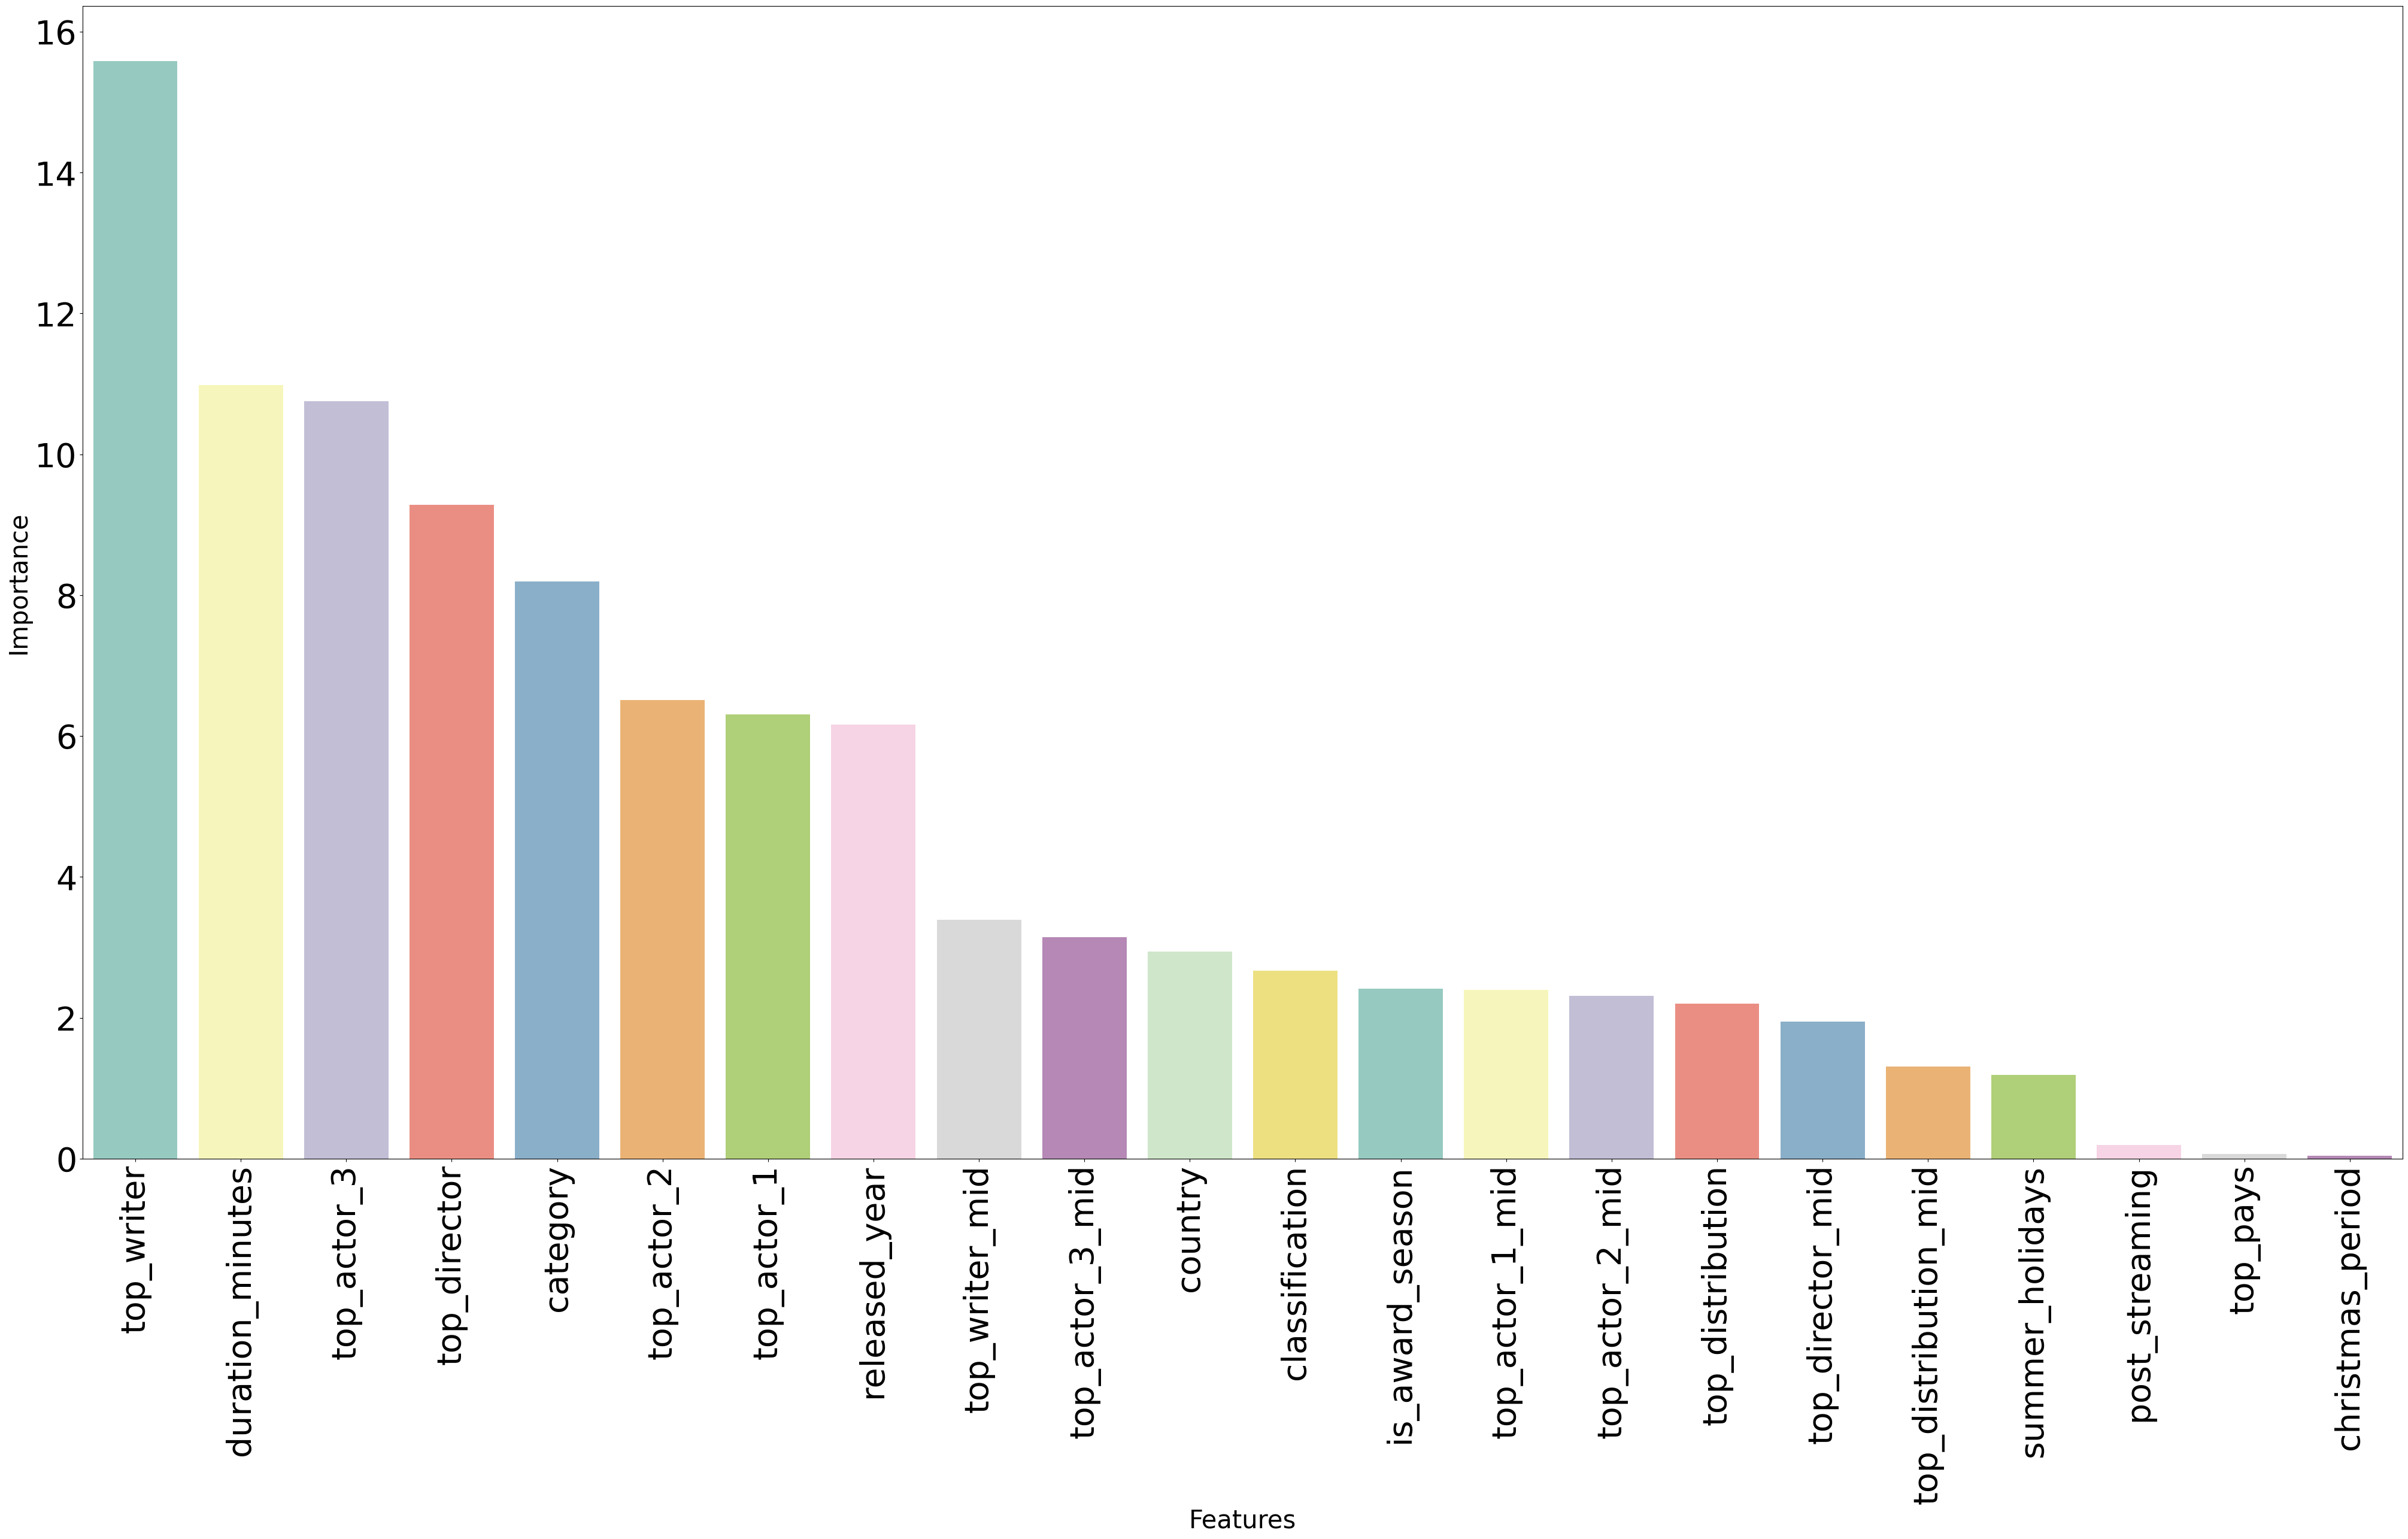

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 25))
sns.barplot(data=feat_imp_df.sort_values(by = 'Importance', ascending=False), x="Feature", y="Importance", palette="Set3")

# Labels axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Taille des ticks
plt.tick_params(axis='both', labelsize=40)

# Rotation des labels en x si besoin (sinon tout se chevauche)
plt.xticks(rotation=90)

plt.show()


In [ ]:
df.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [74]:
from scipy.stats import f_oneway
# Exemple de dataframe df_2_anova
df_2_anova = df.copy()



# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':  # On ne veut pas tester 'weekly_entrances' avec lui-même
        # Créer les groupes selon les valeurs de la colonne discrète
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        # Appliquer le test ANOVA
        stat_anova, p_value = f_oneway(*groups)
        
#         # # Si l'ANOVA est significative (p-value < 0.05), on applique Tukey HSD
#         # if p_value < 0.05:
#         #     # Appliquer le test post-hoc Tukey
#         #     tukey_result = pairwise_tukeyhsd(df_2_anova['weekly_entrances'], df_2_anova[column])
#         #     print(f'Post-hoc Tukey HSD pour {column}:\n', tukey_result.summary())
        
        # Afficher les résultats de l'ANOVA
        print(f'Le résultat pour {column}')
        print("Statistique F:", stat_anova)
        print("P-value:", p_value)
        print('')
        print('================================================================================')


Le résultat pour fr_title
Statistique F: 0.41652693718026995
P-value: 0.9812119563987682

Le résultat pour released_year
Statistique F: 2.9749048311426027
P-value: 1.238115635759097e-10

Le résultat pour directors
Statistique F: 1.5050970011166196
P-value: 5.003036662965276e-35

Le résultat pour writer
Statistique F: 1.4075260181823717
P-value: 8.499730665818995e-24

Le résultat pour distribution
Statistique F: 1.8537591589219735
P-value: 2.0056444949755333e-47

Le résultat pour country
Statistique F: 8.190931457293624
P-value: 1.9089757537287267e-78

Le résultat pour budget
Statistique F: 6.059394708134451
P-value: 0.0

Le résultat pour category
Statistique F: 80.04295805884722
P-value: 5.5e-321

Le résultat pour released_date
Statistique F: 1.0304036874940778
P-value: 0.22050756662100437

Le résultat pour classification
Statistique F: 44.530970788712395
P-value: 8.94625648115363e-54

Le résultat pour duration
Statistique F: 6.1697091752479984
P-value: 9.214400333780716e-108

Le résul

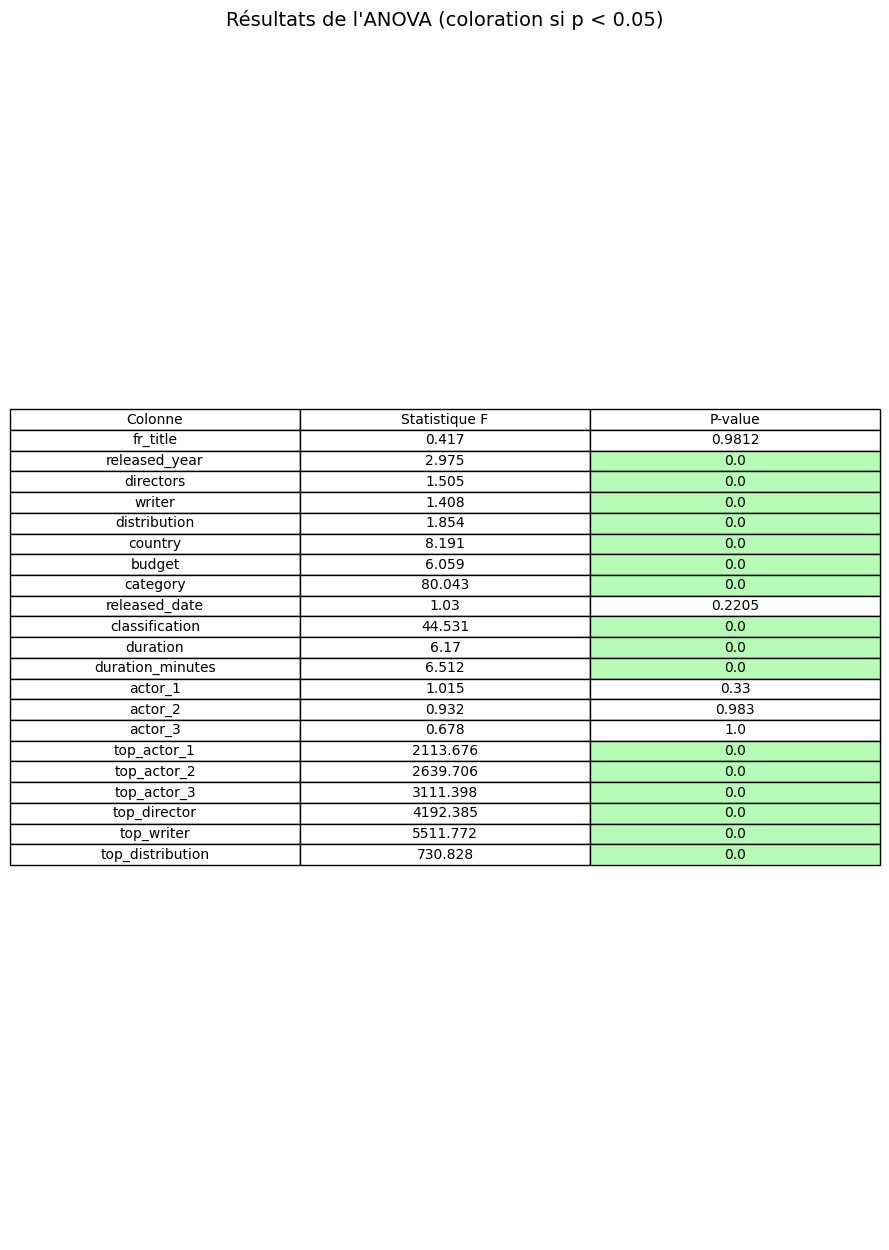

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Exemple de dataframe df_2_anova
df_2_anova = df.copy()

# Liste pour stocker les résultats
results = []

# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        stat_anova, p_value = f_oneway(*groups)
        results.append([column, round(stat_anova, 3), round(p_value, 4)])  # arrondi pour lisibilité

# Créer DataFrame
results_df = pd.DataFrame(results, columns=['Colonne', 'Statistique F', 'P-value'])

# Création du tableau matplotlib
fig, ax = plt.subplots(figsize=(9, len(results_df)*0.6))
ax.axis('off')
ax.axis('tight')

# Création du tableau
table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Appliquer une couleur conditionnelle si p-value < 0.05
for i in range(len(results_df)):
    p_val = results_df.loc[i, 'P-value']
    if p_val < 0.05:
        # Colorier la cellule de la p-value en vert pâle
        table[(i+1, 2)].set_facecolor('#b6fcb6')  # Vert pâle

# Titre
plt.title('Résultats de l\'ANOVA (coloration si p < 0.05)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# 2. Grille de paramètres à tester (tu peux en ajouter)

param_grid = {
    'catboostregressor__depth': [4, 6, 8, 10],
    'catboostregressor__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'catboostregressor__iterations': [200, 300, 500, 700],
    'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 9],
}


# 3. GridSearchCV
grid_search = GridSearchCV(
    catboost_model,
    param_grid,
    cv=3,  # ou 5 pour une validation croisée plus robuste
    scoring='neg_root_mean_squared_error',  # on veut minimiser le RMSE
    n_jobs=4,
    verbose=100
)

# 4. Entraînement
grid_search.fit(X_train, y_train)

# 5. Résultats
print("✅ Best params:", grid_search.best_params_)
print(f"✅ Best RMSE: {-grid_search.best_score_:.4f}")

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV 1/3; 1/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01
[CV 3/3; 1/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01
[CV 2/3; 1/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01
[CV 1/3; 2/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.03
0:	learn: 338616.3556546	total: 47.9ms	remaining: 9.52s
1:	learn: 336649.8022243	total: 49.9ms	remaining: 4.93s
2:	learn: 334732.7413272	total: 50.5ms	remaining: 3.32s
3:	learn: 332782.2512292	total: 51.4ms	remaining: 2.52s
4:	learn: 330808.0228021	total: 52ms	remaining: 2.03s
5:	learn: 329035.0701824	total

In [ ]:
data.columns

Index(['released_year', 'country', 'budget', 'category', 'classification',
       'duration_minutes', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [ ]:
data.classification.unique()

array(['Tout public', 'Interdit - 10 ans', 'Interdit - 6 ans',
       'Interdit - 8 ans', 'Interdit - 12 ans', 'Interdit - 16 ans',
       'Interdit - 18 ans'], dtype=object)

In [ ]:
data.category.unique()

array(['Comédie', 'Science Fiction', 'Comicbook', 'Fantasy',
       'Aventure - Action', 'Guerre', 'Animation', 'Drame', 'Western',
       'Comédie dramatique', 'Thriller', 'Péplum', 'Musical',
       'Film familial', 'Romance', 'Horreur', 'Documentaire',
       'Catastrophe', 'X - Erotique', 'Adaptation Livre', 'Court-métrage',
       'Parodie', 'Action'], dtype=object)

In [ ]:
df_1.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3'],
      dtype='object')

In [9]:
import pandas as pd

# Exemple : colonnes que ton modèle attend (à adapter si besoin)
columns = [
    df_1.columns
]

# Créer un DataFrame vide avec les bonnes colonnes
df_template_test = pd.DataFrame(columns=columns)



# Ajouter un exemple de ligne (ou plusieurs)
df_1_test_film = pd.DataFrame({['fr_title' : "sinners",
                                'released_year': 2025,
                                'directors':"Ryan Coogler", 
                                'writer':"Ryan Coogler", 
                                'distribution':'Universal Pictures International France',
                                'country':'Etats-Unis',
                                 'budget': 90000000,
                                  'category':'Aventure - Action', 
                                  'released_date':"16/04/2025", 
                                  'classification':'Interdit - 12 ans',                               
                                'duration':"2h 17min", 
                                'weekly_entrances': "", 
                                'duration_minutes':137, 
                                'actor_1': "Michael B. Jordan",
                                'actor_2': "Hailee Steinfeld", 
                                'actor_3':"Miles Caton"]
})

# pred_test = catboost_model.predict(df_test)
# print("Prédiction :", round(pred_test[0]))



SyntaxError: invalid syntax (1302379671.py, line 14)